In [ ]:
#pip install paho-mqtt

In [11]:
## Publishing to MQTT + subscribing and printing the message and metadata

import paho.mqtt.client as mqtt
import time

# The callback for when a PUBLISH message is received from the server.
def on_message(client, userdata, message):
    print("message received " ,str(message.payload.decode("utf-8")))
    print("message topic=",message.topic)
    print("message qos=",message.qos)
    print("message retain flag=",message.retain)

publish_key = "pub-c-defc7b94-6e9a-42fd-b25a-883c2e605a89"  #"<your publish key>"
subscribe_key = "sub-c-5a7d9a20-e5a9-11eb-bc98-fa4b4b21bdc4"    #"<your subscribe key>"
client_id = "E4_1"     #"<your unique client identifier>"

print("creating new instance")

client = mqtt.Client(client_id=publish_key + "/" + subscribe_key + "/" + client_id)
client.on_message = on_message
print("connecting to broker")
client.connect("mqtt.pndsn.com", 1883, 60)

client.loop_start() #start the loop

print("Subscribing to topic","E4")
client.subscribe("E4")
print("Publishing message to topic","E4")
client.publish("E4", "Hello World")

time.sleep(4) # wait
client.loop_stop() #stop the loop

creating new instance
connecting to broker
Subscribing to topic E4
Publishing message to topic E4


In [14]:
## Publishing to MQTT + subscribing and printing the message and metadata
## Trying with iot.eclipse.org public server

import paho.mqtt.client as mqtt
import time

# The callback for when a PUBLISH message is received from the server.
def on_message(client, userdata, message):
    print("message received " ,str(message.payload.decode("utf-8")))
    print("message topic=",message.topic)
    print("message qos=",message.qos)
    print("message retain flag=",message.retain)

client_id = "E4"     #"<your unique client identifier>"
broker_address = "test.mosquitto.org"
print("creating new instance")

client = mqtt.Client(client_id) #create new instance
client.on_message = on_message  #attach function to callback
print("connecting to broker")
client.connect(broker_address)  #connect to broker

client.loop_start() #start the loop

print("Subscribing to topic","E4_TB")
client.subscribe("E4_TB")
print("Publishing message to topic","E4_TB")
client.publish("E4_TB", "Hello World")

time.sleep(4) # wait
client.loop_stop() #stop the loop

creating new instance
connecting to broker
Subscribing to topic E4_TB
Publishing message to topic E4_TB
message received  Hello World
message topic= E4_TB
message qos= 0
message retain flag= 0


In [2]:
disconnect()

In [9]:
# Building off earlier version to include real time visualization

## Publishing to MQTT + subscribing and printing the message and metadata from live E4 data
## with public MQTT server
## works to publish and subscribe to data, plus take new data and add it to the growing lists for each attribute and corresponding timestamp


import socket
import time
import pylsl
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import paho.mqtt.client as mqtt
import time

%matplotlib qt
#%matplotlib inline

# SELECT DATA TO STREAM
acc = True      # 3-axis acceleration
bvp = True     # Blood Volume Pulse
gsr = True      # Galvanic Skin Response (Electrodermal Activity)
tmp = True       # Temperature
ibi = False      # Interbeat Interval and Heartbeat
bat = False      # Device Battery
tag = False      # Tag taken from the device (by pressing the button)

serverAddress = '127.0.0.1'
serverPort = 28000
bufferSize = 4096

deviceID = 'CDCB11' # 'A03003'

def connect():
    global s
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.settimeout(3)

    print("Connecting to server")
    s.connect((serverAddress, serverPort))
    print("Connected to server\n")

    print("Devices available:")
    s.send("device_list\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))

    print("Connecting to device")
    s.send(("device_connect " + deviceID + "\r\n").encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))

    print("Pausing data receiving")
    s.send("pause ON\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))
connect()

time.sleep(1)

def suscribe_to_data():
    if acc:
        print("Suscribing to ACC")
        s.send(("device_subscribe " + 'acc' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if bvp:
        print("Suscribing to BVP")
        s.send(("device_subscribe " + 'bvp' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if gsr:
        print("Suscribing to GSR")
        s.send(("device_subscribe " + 'gsr' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if tmp:
        print("Suscribing to Temp")
        s.send(("device_subscribe " + 'tmp' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if ibi:
        print("Suscribing to IBI")
        s.send(("device_subscribe " + 'ibi' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if bat:
        print("Suscribing to Batt")
        s.send(("device_subscribe " + 'bat' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if tag:
        print("Suscribing to Tag")
        s.send(("device_subscribe " + 'tag' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))

    print("Resuming data receiving")
    s.send("pause OFF\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))
suscribe_to_data()

time.sleep(1)

def reconnect():
    print("Reconnecting...")
    connect()
    suscribe_to_data()
    #stream()

def disconnect():
    s.send("device_disconnect\r\n".encode())


""" response = s.recv(bufferSize).decode("utf-8")
    #print(response)
    if "connection lost to device" in response:
        print(response.decode("utf-8"))
        reconnect() """


messages = str()
bvp_timestamp = []
bvp_data = []
temp_timestamp = []
temp_data = []
acc_timestamp = []
acc_data = []
gsr_timestamp = []
gsr_data = []


# The callback for when a PUBLISH message is received from the server.
def on_message(client, userdata, message):
    global messages
    print("message received " ,str(message.payload.decode("utf-8")))
    print("message topic=",message.topic)
    print("message qos=",message.qos)
    print("message retain flag=",message.retain)
    #messages.append(message.payload.decode("utf-8"))
    new_message = str(message.payload.decode("utf-8"))
    messages += new_message
    samples = new_message.split("\r\n")
    for i in range(len(samples)-1):
        stream_type = samples[i].split()[0]
        if stream_type == "E4_Bvp":
            bvp_new_timestamp = float(samples[i].split()[1].replace(',','.'))
            bvp_new_data = float(samples[i].split()[2].replace(',','.'))
            bvp_timestamp.append(bvp_new_timestamp)
            bvp_data.append(bvp_new_data)
        if stream_type == "E4_Temperature":
            temp_new_timestamp = float(samples[i].split()[1].replace(',','.'))
            temp_new_data = float(samples[i].split()[2].replace(',','.'))
            temp_timestamp.append(temp_new_timestamp)
            temp_data.append(temp_new_data)
        if stream_type == "E4_Acc":
            timestamp = float(samples[i].split()[1].replace(',','.'))
            data = [int(samples[i].split()[2].replace(',','.')), int(samples[i].split()[3].replace(',','.')), int(samples[i].split()[4].replace(',','.'))]
            acc_timestamp.append(timestamp)
            acc_data.append(data)
        if stream_type == "E4_Gsr":
            timestamp = float(samples[i].split()[1].replace(',','.'))
            data = float(samples[i].split()[2].replace(',','.'))
            gsr_timestamp.append(timestamp)
            gsr_data.append(data)
        """ if stream_type == "E4_Ibi":
            timestamp = float(samples[i].split()[1].replace(',','.'))
            data = float(samples[i].split()[2].replace(',','.'))
            #ibi_timestamp.append(timestamp)
            #ibi_data.append(data)            
        if stream_type == "E4_Tag":
            timestamp = float(samples[i].split()[1].replace(',','.'))
            data = float(samples[i].split()[2].replace(',','.'))
            
        if stream_type == "E4_Battery":
            timestamp = float(samples[i].split()[1].replace(',','.'))
            data = float(samples[i].split()[2].replace(',','.')) """
            
plt.style.use('fivethirtyeight')
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex=True)

def animate(i):
    response = s.recv(bufferSize).decode("utf-8")
    #print(response)
    if "connection lost to device" in response:
        print(response.decode("utf-8"))
        reconnect()
    
    client.subscribe("E4_TB")

    #client.publish("E4_TB", response)

    ax1.cla()
    ax1.plot([dt.datetime.fromtimestamp(ts) for ts in acc_timestamp], acc_data)
    ax1.set_ylabel('Acc (1/64 g)')
    #ax1.legend(iter(lineObjects), ('X', 'Y', 'Z'), loc='upper left')        
    
    ax2.cla()
    ax2.plot([dt.datetime.fromtimestamp(ts) for ts in bvp_timestamp], bvp_data)
    ax2.set_ylabel('BVP')

    ax3.cla()
    ax3.plot([dt.datetime.fromtimestamp(ts) for ts in gsr_timestamp], gsr_data)
    ax3.set_ylabel('GSR')

    ax4.cla()
    ax4.plot([dt.datetime.fromtimestamp(ts) for ts in temp_timestamp], temp_data)
    ax4.set_ylabel('Temp ($^\circ$C)')
    ax4.set_xlabel('Time')    

client_id = "E4"     #"<your unique client identifier>"
broker_address = "test.mosquitto.org"
print("creating new instance")

client = mqtt.Client(client_id) #create new instance
client.on_message = on_message  #attach function to callback
print("connecting to broker")
client.connect(broker_address)  #connect to broker
print("creating new instance")

client.loop_start() #start the loop

""" print("Subscribing to topic","E4_TB")
client.subscribe("E4_TB")
print("Publishing message to topic","E4_TB") """


ani = FuncAnimation(plt.gcf(), animate, interval = 10)

while True:
    response = s.recv(bufferSize).decode("utf-8")
    client.publish("E4_TB", response)
    #time.sleep(40) # wait

plt.tight_layout
plt.show()

client.loop_stop() #stop the loop
disconnect()


Connecting to server
Connected to server

Devices available:
R device_list 1 | CDCB11 Empatica_E4 

Connecting to device
R device_connect OK

Pausing data receiving
R pause ON

Suscribing to ACC
R device_subscribe acc OK

Suscribing to BVP
R device_subscribe bvp OK

Suscribing to GSR
R device_subscribe gsr OK

Suscribing to Temp
R device_subscribe tmp OK

Resuming data receiving
R pause OFF

creating new instance
connecting to broker
creating new instance


ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

# Code below works but no visualizations

In [1]:
## Publishing to MQTT + subscribing and printing the message and metadata from live E4 data
## with public MQTT server
## works to publish and subscribe to data, plus take new data and add it to the growing lists for each attribute and corresponding timestamp


import socket
import time
import pylsl
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
%matplotlib qt
#%matplotlib inline

# SELECT DATA TO STREAM
acc = True      # 3-axis acceleration
bvp = True     # Blood Volume Pulse
gsr = True      # Galvanic Skin Response (Electrodermal Activity)
tmp = True       # Temperature
ibi = False      # Interbeat Interval and Heartbeat
bat = False      # Device Battery
tag = False      # Tag taken from the device (by pressing the button)

serverAddress = '127.0.0.1'
serverPort = 28000
bufferSize = 4096

deviceID = 'CDCB11' # 'A03003'

def connect():
    global s
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.settimeout(3)

    print("Connecting to server")
    s.connect((serverAddress, serverPort))
    print("Connected to server\n")

    print("Devices available:")
    s.send("device_list\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))

    print("Connecting to device")
    s.send(("device_connect " + deviceID + "\r\n").encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))

    print("Pausing data receiving")
    s.send("pause ON\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))
connect()

time.sleep(1)

def suscribe_to_data():
    if acc:
        print("Suscribing to ACC")
        s.send(("device_subscribe " + 'acc' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if bvp:
        print("Suscribing to BVP")
        s.send(("device_subscribe " + 'bvp' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if gsr:
        print("Suscribing to GSR")
        s.send(("device_subscribe " + 'gsr' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if tmp:
        print("Suscribing to Temp")
        s.send(("device_subscribe " + 'tmp' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if ibi:
        print("Suscribing to IBI")
        s.send(("device_subscribe " + 'ibi' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if bat:
        print("Suscribing to Batt")
        s.send(("device_subscribe " + 'bat' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if tag:
        print("Suscribing to Tag")
        s.send(("device_subscribe " + 'tag' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))

    print("Resuming data receiving")
    s.send("pause OFF\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))
suscribe_to_data()

time.sleep(1)

def reconnect():
    print("Reconnecting...")
    connect()
    suscribe_to_data()
    #stream()

def disconnect():
    s.send("device_disconnect\r\n".encode())


""" response = s.recv(bufferSize).decode("utf-8")
    #print(response)
    if "connection lost to device" in response:
        print(response.decode("utf-8"))
        reconnect() """



import paho.mqtt.client as mqtt
import time


messages = str()
bvp_timestamp = []
bvp_data = []
temp_timestamp = []
temp_data = []
acc_timestamp = []
acc_data = []
gsr_timestamp = []
gsr_data = []


# The callback for when a PUBLISH message is received from the server.
def on_message(client, userdata, message):
    global messages
    print("message received " ,str(message.payload.decode("utf-8")))
    print("message topic=",message.topic)
    print("message qos=",message.qos)
    print("message retain flag=",message.retain)
    #messages.append(message.payload.decode("utf-8"))
    new_message = str(message.payload.decode("utf-8"))
    messages += new_message
    samples = new_message.split("\r\n")
    for i in range(len(samples)-1):
        stream_type = samples[i].split()[0]
        if stream_type == "E4_Bvp":
            bvp_new_timestamp = float(samples[i].split()[1].replace(',','.'))
            bvp_new_data = float(samples[i].split()[2].replace(',','.'))
            bvp_timestamp.append(bvp_new_timestamp)
            bvp_data.append(bvp_new_data)
        if stream_type == "E4_Temperature":
            temp_new_timestamp = float(samples[i].split()[1].replace(',','.'))
            temp_new_data = float(samples[i].split()[2].replace(',','.'))
            temp_timestamp.append(temp_new_timestamp)
            temp_data.append(temp_new_data)
        if stream_type == "E4_Acc":
            timestamp = float(samples[i].split()[1].replace(',','.'))
            data = [int(samples[i].split()[2].replace(',','.')), int(samples[i].split()[3].replace(',','.')), int(samples[i].split()[4].replace(',','.'))]
            acc_timestamp.append(timestamp)
            acc_data.append(data)
        if stream_type == "E4_Gsr":
            timestamp = float(samples[i].split()[1].replace(',','.'))
            data = float(samples[i].split()[2].replace(',','.'))
            gsr_timestamp.append(timestamp)
            gsr_data.append(data)
        """ if stream_type == "E4_Ibi":
            timestamp = float(samples[i].split()[1].replace(',','.'))
            data = float(samples[i].split()[2].replace(',','.'))
            #ibi_timestamp.append(timestamp)
            #ibi_data.append(data)            
        if stream_type == "E4_Tag":
            timestamp = float(samples[i].split()[1].replace(',','.'))
            data = float(samples[i].split()[2].replace(',','.'))
            
        if stream_type == "E4_Battery":
            timestamp = float(samples[i].split()[1].replace(',','.'))
            data = float(samples[i].split()[2].replace(',','.')) """
            
    

client_id = "E4"     #"<your unique client identifier>"
broker_address = "test.mosquitto.org"
print("creating new instance")

client = mqtt.Client(client_id) #create new instance
client.on_message = on_message  #attach function to callback
print("connecting to broker")
client.connect(broker_address)  #connect to broker
print("creating new instance")

client.loop_start() #start the loop

print("Subscribing to topic","E4_TB")
client.subscribe("E4_TB")
print("Publishing message to topic","E4_TB")
while True:
    response = s.recv(bufferSize).decode("utf-8")
    client.publish("E4_TB", response)
    #time.sleep(40) # wait


client.loop_stop() #stop the loop
disconnect()


Connecting to server
Connected to server

Devices available:
R device_list 1 | CDCB11 Empatica_E4 

Connecting to device
R device_connect OK

Pausing data receiving
R pause ON

Suscribing to ACC
R device_subscribe acc OK

Suscribing to BVP
R device_subscribe bvp OK

Suscribing to GSR
R device_subscribe gsr OK

Suscribing to Temp
R device_subscribe tmp OK

Resuming data receiving
R pause OFF

creating new instance
connecting to broker
creating new instance
Subscribing to topic E4_TB
Publishing message to topic E4_TB
message received  E4_Acc 1626468886.02502 -2 60 8
E4_Acc 1626468886.05627 -2 60 8
E4_Acc 1626468886.08752 -2 60 8
E4_Acc 1626468886.11877 -2 60 8
E4_Acc 1626468886.15003 -2 60 8
E4_Acc 1626468886.18128 -2 60 8
E4_Bvp 1626468886.10224 -1.019156
E4_Bvp 1626468886.11786 -1.007515
E4_Bvp 1626468886.13349 -0.8766075
E4_Bvp 1626468886.14911 -0.6707287
E4_Bvp 1626468886.16474 -0.428167
E4_Bvp 1626468886.18036 -0.1583894
E4_Bvp 1626468886.19599 0.1585827
E4_Bvp 1626468886.21162 0.52

KeyboardInterrupt: 

message received  E4_Bvp 1626468912.40033 -0.3570576
E4_Bvp 1626468912.41595 1.473324

message topic= E4_TB
message qos= 0
message retain flag= 0
message received  E4_Bvp 1626468912.43158 2.172702
E4_Bvp 1626468912.44721 2.269065

message topic= E4_TB
message qos= 0
message retain flag= 0
message received  E4_Bvp 1626468912.46283 2.233776
E4_Bvp 1626468912.47846 2.299306
E4_Bvp 1626468912.49408 2.455115
E4_Bvp 1626468912.50971 2.584487
E4_Bvp 1626468912.52533 2.591039
E4_Bvp 1626468912.54096 2.453153
E4_Bvp 1626468912.55659 2.22287

message topic= E4_TB
message qos= 0
message retain flag= 0
message received  E4_Acc 1626468912.46374 4 4 55
E4_Acc 1626468912.495 4 -15 46

message topic= E4_TB
message qos= 0
message retain flag= 0
message received  E4_Acc 1626468912.52625 -6 -20 48
E4_Acc 1626468912.5575 -7 -20 54
E4_Acc 1626468912.58875 -1 -46 54
E4_Acc 1626468912.62 -7 -52 50

message topic= E4_TB
message qos= 0
message retain flag= 0


In [6]:
disconnect()

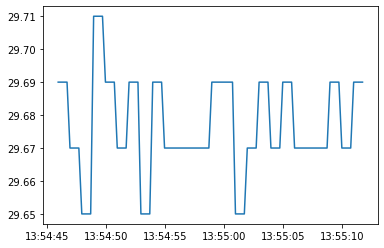

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import datetime as dt

plt.plot([dt.datetime.fromtimestamp(ts) for ts in temp_timestamp], temp_data)

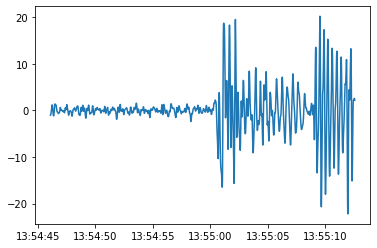

In [4]:
import matplotlib.pyplot as plt
import datetime as dt

plt.plot([dt.datetime.fromtimestamp(ts) for ts in bvp_timestamp], bvp_data)

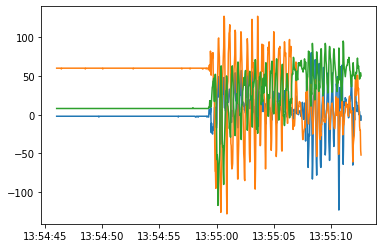

In [5]:
plt.plot([dt.datetime.fromtimestamp(ts) for ts in acc_timestamp], acc_data)

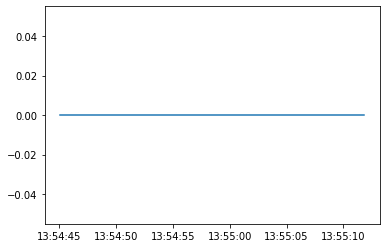

In [6]:
plt.plot([dt.datetime.fromtimestamp(ts) for ts in gsr_timestamp], gsr_data)

In [3]:
messages

'E4_Temperature 1626464053.73998 29.21\r\nE4_Temperature 1626464053.98999 29.21\r\nE4_Temperature 1626464054.24 29.21\r\nE4_Temperature 1626464054.49001 29.21\r\nE4_Temperature 1626464054.74002 29.19\r\nE4_Temperature 1626464054.99003 29.19\r\nE4_Temperature 1626464055.24005 29.19\r\nE4_Temperature 1626464055.49006 29.19\r\nE4_Temperature 1626464055.74007 29.21\r\nE4_Temperature 1626464055.99008 29.21\r\nE4_Temperature 1626464056.24009 29.21\r\nE4_Temperature 1626464056.4901 29.21\r\nE4_Temperature 1626464056.74012 29.21\r\nE4_Temperature 1626464056.99013 29.21\r\nE4_Temperature 1626464057.24014 29.21\r\nE4_Temperature 1626464057.49015 29.21\r\nE4_Temperature 1626464057.74016 29.21\r\nE4_Temperature 1626464057.99017 29.21\r\nE4_Temperature 1626464058.24018 29.21\r\nE4_Temperature 1626464058.4902 29.21\r\nE4_Temperature 1626464058.74021 29.19\r\nE4_Temperature 1626464058.99022 29.19\r\nE4_Temperature 1626464059.24023 29.19\r\nE4_Temperature 1626464059.49024 29.19\r\nE4_Temperature 16264

In [5]:
samples = messages.split('\r\n')
print(samples)

['E4_Temperature 1626463595.71877 29.29', 'E4_Temperature 1626463595.96878 29.29', 'E4_Temperature 1626463596.21879 29.29', 'E4_Temperature 1626463596.46881 29.29', 'E4_Temperature 1626463596.71882 29.27', 'E4_Temperature 1626463596.96883 29.27', 'E4_Temperature 1626463597.21884 29.27', 'E4_Temperature 1626463597.46885 29.27', 'E4_Temperature 1626463597.71886 29.29', 'E4_Temperature 1626463597.96888 29.29', 'E4_Temperature 1626463598.21889 29.29', 'E4_Temperature 1626463598.4689 29.29', 'E4_Temperature 1626463598.71891 29.27', 'E4_Temperature 1626463598.96892 29.27', 'E4_Temperature 1626463599.21893 29.27', 'E4_Temperature 1626463599.46894 29.27', 'E4_Temperature 1626463599.71896 29.27', 'E4_Temperature 1626463599.96897 29.27', 'E4_Temperature 1626463600.21898 29.27', 'E4_Temperature 1626463600.46899 29.27', 'E4_Temperature 1626463600.719 29.27', 'E4_Temperature 1626463600.96901 29.27', 'E4_Temperature 1626463601.21903 29.27', 'E4_Temperature 1626463601.46904 29.27', 'E4_Temperature 16

In [6]:
samples[1]

'E4_Temperature 1626463595.96878 29.29'

In [ ]:
for i in range(len(samples)-1):
    stream_type = samples[i].split()[0]
    print(stream_type)

In [8]:
stream_type

'E4_Temperature'

In [16]:
response

'E4_Temperature 1626463088.1166 28.83\r\nE4_Temperature 1626463088.36661 28.83\r\n'

In [7]:
messages

['E4_Temperature 1626461078.44087 29.61\r\nE4_Temperature 1626461078.69088 29.61\r\n',
 'E4_Temperature 1626461078.94089 29.61\r\nE4_Temperature 1626461079.1909 29.61\r\nE4_Temperature 1626461079.44092 29.61\r\nE4_Temperature 1626461079.69093 29.61\r\nE4_Temperature 1626461079.94094 29.61\r\nE4_Temperature 1626461080.19095 29.61\r\n']

In [16]:
sample = messages[0].split("\n")
print(sample)

['E4_Temperature 1626461078.44087 29.61\r', 'E4_Temperature 1626461078.69088 29.61\r', '']


In [18]:
for i in range(len(sample)-1):
    print(sample[i])

E4_Temperature 1626461078.44087 29.61
E4_Temperature 1626461078.69088 29.61


In [20]:
sample[1]

'E4_Temperature 1626461078.69088 29.61\r'

In [15]:
## Publishing to MQTT + subscribing and printing the message and metadata from live E4 data


import socket
import time
import pylsl
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import threading
%matplotlib qt
#%matplotlib inline

# SELECT DATA TO STREAM
acc = False      # 3-axis acceleration
bvp = False      # Blood Volume Pulse
gsr = False      # Galvanic Skin Response (Electrodermal Activity)
tmp = True       # Temperature
ibi = False      # Interbeat Interval and Heartbeat
bat = False      # Device Battery
tag = False      # Tag taken from the device (by pressing the button)

serverAddress = '127.0.0.1'
serverPort = 28000
bufferSize = 4096

deviceID = 'CDCB11' # 'A03003'

def connect():
    global s
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.settimeout(3)

    print("Connecting to server")
    s.connect((serverAddress, serverPort))
    print("Connected to server\n")

    print("Devices available:")
    s.send("device_list\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))

    print("Connecting to device")
    s.send(("device_connect " + deviceID + "\r\n").encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))

    print("Pausing data receiving")
    s.send("pause ON\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))
connect()

time.sleep(1)

def suscribe_to_data():
    if acc:
        print("Suscribing to ACC")
        s.send(("device_subscribe " + 'acc' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if bvp:
        print("Suscribing to BVP")
        s.send(("device_subscribe " + 'bvp' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if gsr:
        print("Suscribing to GSR")
        s.send(("device_subscribe " + 'gsr' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if tmp:
        print("Suscribing to Temp")
        s.send(("device_subscribe " + 'tmp' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if ibi:
        print("Suscribing to IBI")
        s.send(("device_subscribe " + 'ibi' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if bat:
        print("Suscribing to Batt")
        s.send(("device_subscribe " + 'bat' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if tag:
        print("Suscribing to Tag")
        s.send(("device_subscribe " + 'tag' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))

    print("Resuming data receiving")
    s.send("pause OFF\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))
suscribe_to_data()

time.sleep(1)

def reconnect():
    print("Reconnecting...")
    connect()
    suscribe_to_data()
    #stream()

def disconnect():
    s.send("device_disconnect\r\n".encode())


""" response = s.recv(bufferSize).decode("utf-8")
    #print(response)
    if "connection lost to device" in response:
        print(response.decode("utf-8"))
        reconnect() """



import paho.mqtt.client as mqtt
import time

""" messages = []
temp_timestamp = []
temp_data = [] """

# The callback for when a PUBLISH message is received from the server.
def on_message(client, userdata, message):
    print("message received " ,str(message.payload.decode("utf-8")))
    print("message topic=",message.topic)
    print("message qos=",message.qos)
    print("message retain flag=",message.retain)
    #messages.append(message.payload.decode("utf-8"))
    """ new_message = message.payload.decode("utf-8")
    samples = new_message.split("\n")
    for i in range(len(samples)-1):
        stream_type = samples[i].split()[0]
        if stream_type == "E4_Temperature":
            temp_new_timestamp = float(samples[i].split()[1].replace(',','.'))
            temp_new_data = float(samples[i].split()[2].replace(',','.'))
            temp_timestamp.append(temp_new_timestamp)
            temp_data.append(temp_new_data) """
    

publish_key = "pub-c-defc7b94-6e9a-42fd-b25a-883c2e605a89"  #"<your publish key>"
subscribe_key = "sub-c-5a7d9a20-e5a9-11eb-bc98-fa4b4b21bdc4"    #"<your subscribe key>"
client_id = "E4_1"     #"<your unique client identifier>"

print("creating new instance")

client = mqtt.Client(client_id=publish_key + "/" + subscribe_key + "/" + client_id)
client.on_message = on_message
print("connecting to broker")
client.connect("mqtt.pndsn.com", 1883, 60)

client.loop_start() #start the loop

print("Subscribing to topic","E4")
client.subscribe("E4_TB")
print("Publishing message to topic","E4")
while True:
    response = s.recv(bufferSize).decode("utf-8")
    client.publish("E4_TB", response)
    #time.sleep(40) # wait


client.loop_stop() #stop the loop
disconnect()


Connecting to server
Connected to server

Devices available:
R device_list 1 | CDCB11 Empatica_E4 

Connecting to device
R device_connect OK

Pausing data receiving
R pause ON

Suscribing to Temp
R device_subscribe tmp OK

Resuming data receiving
R pause OFF

creating new instance
connecting to broker
Subscribing to topic E4
Publishing message to topic E4


KeyboardInterrupt: 

In [9]:
disconnect()

In [10]:
response

'E4_Temperature 1626459586.12178 28.05\r\n'

In [7]:
response

'E4_Temperature 1626459424.11428 26.13\r\n'

In [50]:
temp_data

[31.61,
 31.61,
 31.61,
 31.61,
 31.61,
 31.61,
 31.61,
 31.61,
 31.61,
 31.61,
 31.61,
 31.61,
 31.61,
 31.61,
 31.61,
 31.61,
 31.61,
 31.61,
 31.61,
 31.61,
 31.59,
 31.59,
 31.59,
 31.59]

In [51]:
temp_timestamp

[1626394667.00535,
 1626394667.25536,
 1626394667.50538,
 1626394667.75539,
 1626394668.0054,
 1626394668.25541,
 1626394668.50542,
 1626394668.75543,
 1626394669.00545,
 1626394669.25546,
 1626394669.50547,
 1626394669.75548,
 1626394670.00549,
 1626394670.2555,
 1626394670.50551,
 1626394670.75553,
 1626394671.00554,
 1626394671.25555,
 1626394671.50556,
 1626394671.75557,
 1626394672.00558,
 1626394672.2556,
 1626394672.50561,
 1626394672.75562]

In [33]:
messages

['E4_Temperature 1626393934.97146 31.69\r\nE4_Temperature 1626393935.22147 31.69\r\n',
 'E4_Temperature 1626393935.47149 31.69\r\nE4_Temperature 1626393935.7215 31.69\r\nE4_Temperature 1626393935.97151 31.69\r\nE4_Temperature 1626393936.22152 31.69\r\nE4_Temperature 1626393936.47153 31.69\r\nE4_Temperature 1626393936.72154 31.69\r\n',
 'E4_Temperature 1626393936.97155 31.69\r\n',
 'E4_Temperature 1626393937.22157 31.69\r\nE4_Temperature 1626393937.47158 31.69\r\nE4_Temperature 1626393937.72159 31.69\r\n',
 'E4_Temperature 1626393937.9716 31.71\r\nE4_Temperature 1626393938.22161 31.71\r\n',
 'E4_Temperature 1626393938.47162 31.71\r\nE4_Temperature 1626393938.72164 31.71\r\n',
 'E4_Temperature 1626393938.97165 31.69\r\nE4_Temperature 1626393939.22166 31.69\r\n',
 'E4_Temperature 1626393939.47167 31.69\r\nE4_Temperature 1626393939.72168 31.69\r\nE4_Temperature 1626393939.97169 31.69\r\nE4_Temperature 1626393940.2217 31.69\r\nE4_Temperature 1626393940.47172 31.69\r\nE4_Temperature 16263939

In [34]:
for i in messages:
    print (i)

E4_Temperature 1626393934.97146 31.69
E4_Temperature 1626393935.22147 31.69

E4_Temperature 1626393935.47149 31.69
E4_Temperature 1626393935.7215 31.69
E4_Temperature 1626393935.97151 31.69
E4_Temperature 1626393936.22152 31.69
E4_Temperature 1626393936.47153 31.69
E4_Temperature 1626393936.72154 31.69

E4_Temperature 1626393936.97155 31.69

E4_Temperature 1626393937.22157 31.69
E4_Temperature 1626393937.47158 31.69
E4_Temperature 1626393937.72159 31.69

E4_Temperature 1626393937.9716 31.71
E4_Temperature 1626393938.22161 31.71

E4_Temperature 1626393938.47162 31.71
E4_Temperature 1626393938.72164 31.71

E4_Temperature 1626393938.97165 31.69
E4_Temperature 1626393939.22166 31.69

E4_Temperature 1626393939.47167 31.69
E4_Temperature 1626393939.72168 31.69
E4_Temperature 1626393939.97169 31.69
E4_Temperature 1626393940.2217 31.69
E4_Temperature 1626393940.47172 31.69
E4_Temperature 1626393940.72173 31.69

E4_Temperature 1626393940.97174 31.67

E4_Temperature 1626393941.22175 31.67
E4_Tem

In [16]:
samples_test = messages.split("\n")

AttributeError: 'list' object has no attribute 'split'

In [17]:
"test" + "test"

'testtest'

In [9]:
for i in messages:
        stream_type = messages[i].split()[0]
        print(stream_type)

TypeError: list indices must be integers or slices, not str

In [7]:
for i in messages:
    print(i)

E4_Temperature 1626392588.90914 30.95
E4_Temperature 1626392589.15916 30.95
E4_Temperature 1626392589.40917 30.95
E4_Temperature 1626392589.65918 30.95
E4_Temperature 1626392589.90919 30.95
E4_Temperature 1626392590.1592 30.95
E4_Temperature 1626392590.40921 30.95
E4_Temperature 1626392590.65922 30.95

E4_Temperature 1626392590.90924 30.97
E4_Temperature 1626392591.15925 30.97

E4_Temperature 1626392591.40926 30.97
E4_Temperature 1626392591.65927 30.97
E4_Temperature 1626392591.90928 30.95
E4_Temperature 1626392592.15929 30.95

E4_Temperature 1626392592.40931 30.95
E4_Temperature 1626392592.65932 30.95

E4_Temperature 1626392592.90933 30.95

E4_Temperature 1626392593.15934 30.95
E4_Temperature 1626392593.40935 30.95
E4_Temperature 1626392593.65936 30.95
E4_Temperature 1626392593.90937 30.95
E4_Temperature 1626392594.15939 30.95
E4_Temperature 1626392594.4094 30.95
E4_Temperature 1626392594.65941 30.95

E4_Temperature 1626392594.90942 30.95
E4_Temperature 1626392595.15943 30.95

E4_Temp